In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import matplotlib as mpl
import matplotlib.pyplot as plt

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.0


In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_val_data_gen = ImageDataGenerator(rescale=1/255.,validation_split=0.2)

data_dir = '../input/dataset/training'

train_gen = train_val_data_gen.flow_from_directory(directory=data_dir,
                                               target_size=(256,256),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=True,
                                               seed=seed,
                                               subset='training')
val_gen = train_val_data_gen.flow_from_directory(directory=data_dir,
                                               target_size=(256,256),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=True,
                                               seed=seed,
                                               subset='validation')

Found 14189 images belonging to 14 classes.
Found 3539 images belonging to 14 classes.


In [ ]:
input_shape = (256, 256, 3)
epochs = 100

In [ ]:
def build_model(input_shape):

    input_layer = tfkl.Input(shape=input_shape, name='Input')

    conv1 = tfkl.Conv2D(
        filters=16,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(input_layer)
    pool1 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv1)

    conv2 = tfkl.Conv2D(
        filters=32,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool1)
    pool2 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv2)

    conv3 = tfkl.Conv2D(
        filters=64,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool2)
    pool3 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv3)

    conv4 = tfkl.Conv2D(
        filters=128,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool3)
    pool4 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv4)

    conv5 = tfkl.Conv2D(
        filters=256,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool4)
    pool5 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv5)

    flattening_layer = tfkl.Flatten(name='Flatten')(pool5)
    flattening_layer = tfkl.Dropout(0.3, seed=seed)(flattening_layer)
    classifier_layer = tfkl.Dense(units=512, name='Classifier', kernel_initializer=tfk.initializers.GlorotUniform(seed), activation='relu')(flattening_layer)
    classifier_layer = tfkl.Dropout(0.3, seed=seed)(classifier_layer)
    output_layer = tfkl.Dense(units=14, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='Output')(classifier_layer)

    # Connect input and output through the Model class
    es_model = tfk.Model(inputs=input_layer, outputs=output_layer, name='ES-Rescaling-Dropout')

    # Compile the model
    es_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return es_model

2021-11-27 15:47:49.761379: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-27 15:47:49.870128: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-27 15:47:49.870857: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-27 15:47:49.872186: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "ES-Rescaling-Dropout"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64

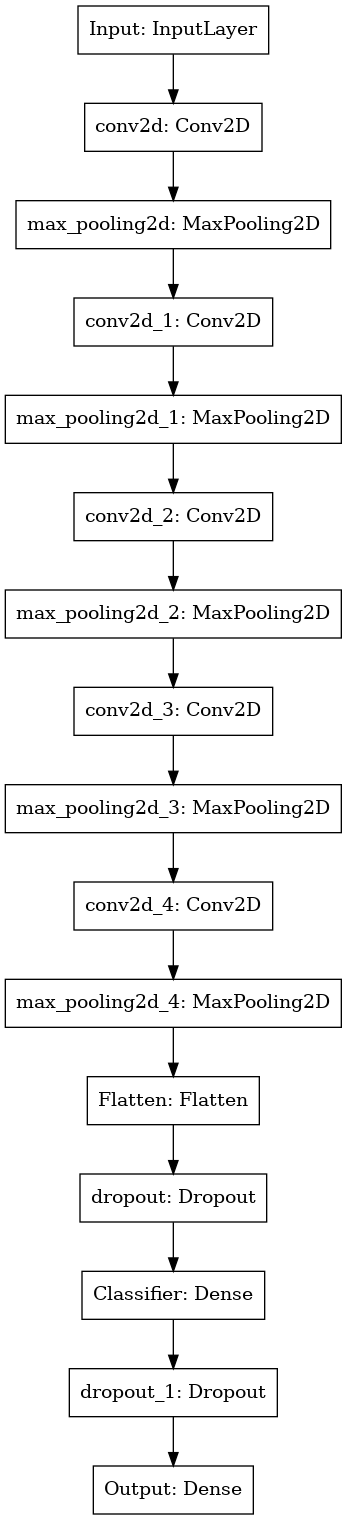

In [ ]:
es_model = build_model(input_shape)
es_model.summary()
tfk.utils.plot_model(es_model)

In [ ]:
patience = 25
early_stopping = tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=patience, restore_best_weights=True)

In [ ]:
es_history = es_model.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = val_gen,
    callbacks = [early_stopping],
).history

2021-11-27 15:47:53.151239: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2021-11-27 15:47:54.643325: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1774/1774 [==============================] - 89s 46ms/step - loss: 1.0278 - accuracy: 0.6864 - val_loss: 0.7844 - val_accuracy: 0.7607
Epoch 2/100
1774/1774 [==============================] - 48s 27ms/step - loss: 0.4709 - accuracy: 0.8482 - val_loss: 0.6628 - val_accuracy: 0.8141
Epoch 3/100
1774/1774 [==============================] - 46s 26ms/step - loss: 0.3096 - accuracy: 0.8981 - val_loss: 0.5063 - val_accuracy: 0.8647
Epoch 4/100
1774/1774 [==============================] - 46s 26ms/step - loss: 0.2166 - accuracy: 0.9285 - val_loss: 0.6407 - val_accuracy: 0.8655
Epoch 5/100
1774/1774 [==============================] - 46s 26ms/step - loss: 0.1676 - accuracy: 0.9462 - val_loss: 0.4850 - val_accuracy: 0.8802
Epoch 6/100
1774/1774 [==============================] - 55s 31ms/step - loss: 0.1357 - accuracy: 0.9559 - val_loss: 0.6393 - val_accuracy: 0.8548
Epoch 7/100
1774/1774 [==============================] - 51s 29ms/step - loss: 0.1255 - accuracy: 0.9614 - val_loss: 0.4442 - val_

In [ ]:
es_model.save('ES-Rescaling-Dropout')

2021-11-27 16:33:56.186956: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


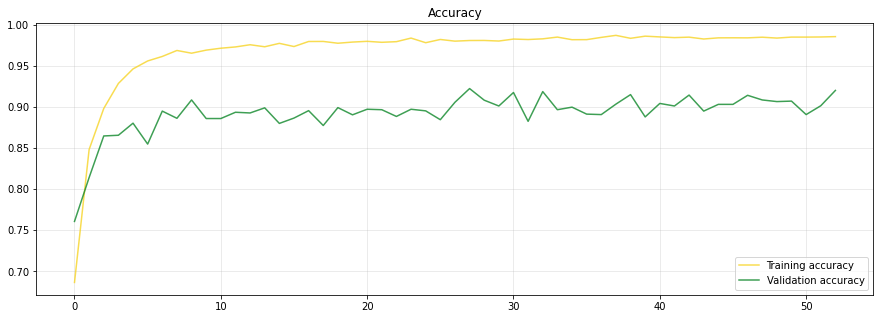

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(es_history['accuracy'], label='Training accuracy', alpha=.8, color='#F7D426')
plt.plot(es_history['val_accuracy'], label='Validation accuracy', alpha=.8, color='#0E8729')
plt.title('Accuracy')
plt.legend(loc='lower right')
plt.grid(alpha=.3)
plt.savefig('ES-Rescaling-Dropout-graph.png')
plt.show()